In [1]:
import sys

import pandas as pd

import superlets_package.superlets

sys.path.insert(0, '..')

In [2]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import importlib
import scipy.signal as signal_scipy
import os

from scipy.ndimage import gaussian_filter1d

import superlets_package.morlet as morlet
import superlets_package.superlets as superlet

In [3]:
importlib.reload(superlet)

<module 'superlets_package.superlets' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/superlets.py'>

In [4]:
importlib.reload(morlet)

<module 'superlets_package.morlet' from '/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/superlets_package/morlet.py'>

# Create simulated EMG signals

### Signal parameters

In [5]:
fs = 1024
signal_duration = 3
t = np.linspace(0, signal_duration, signal_duration * fs)

### Baseline noise

In [6]:
noise = np.random.normal(0, 0.01, len(t))

### Burst parameters

In [7]:
burst_duration = 1
burst_start = 1
real_t_onset = burst_start
real_t_offset = burst_start + burst_duration

### De Luca method to create burst with a known frequency

MNF ideal = 40.77148546557233
MNF analytic = 41.092676659685516


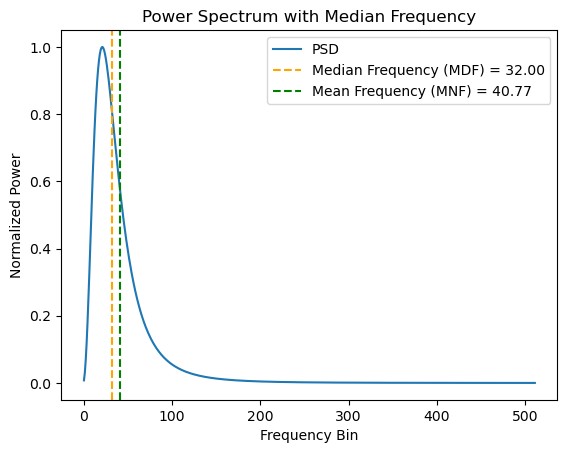

In [8]:
burst = []
[filtro, PdeLuca, burst, MNF_ideal, MNF_analytic] = superlet.fdeluca(40, 20, fs, burst_duration, plot = False)
print(f'MNF ideal = {MNF_ideal}')
print(f'MNF analytic = {MNF_analytic}')

### Add noise to the signal with a particular value for SNR

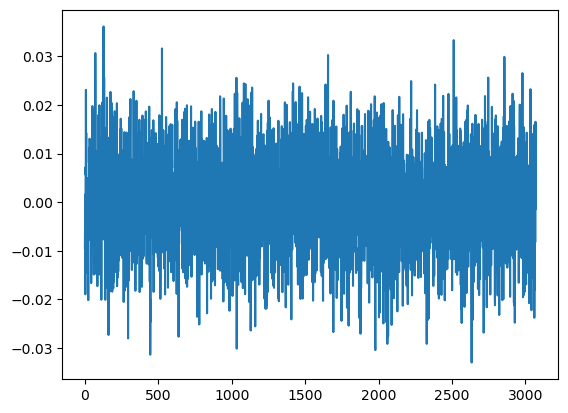

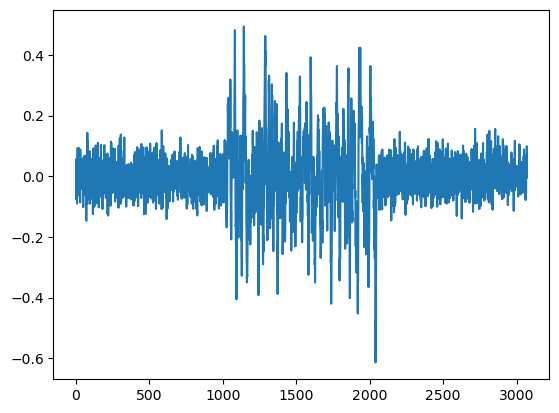

In [9]:
filename = "/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/RESULTS/signal_burst_1.npy"

if os.path.exists(filename):
    burst_signal = np.load(filename)
else:
    burst_signal = noise.copy()
    burst_signal[int(burst_start * fs):int(burst_start * fs + len(burst))] += burst
    np.save('/Users/neuralrehabilitationgroup/PycharmProjects/Superlets-Marina/RESULTS/signal_burst_1.npy', burst_signal)

plt.plot(noise)
plt.figure()
plt.plot(burst_signal)

### Signal visualization

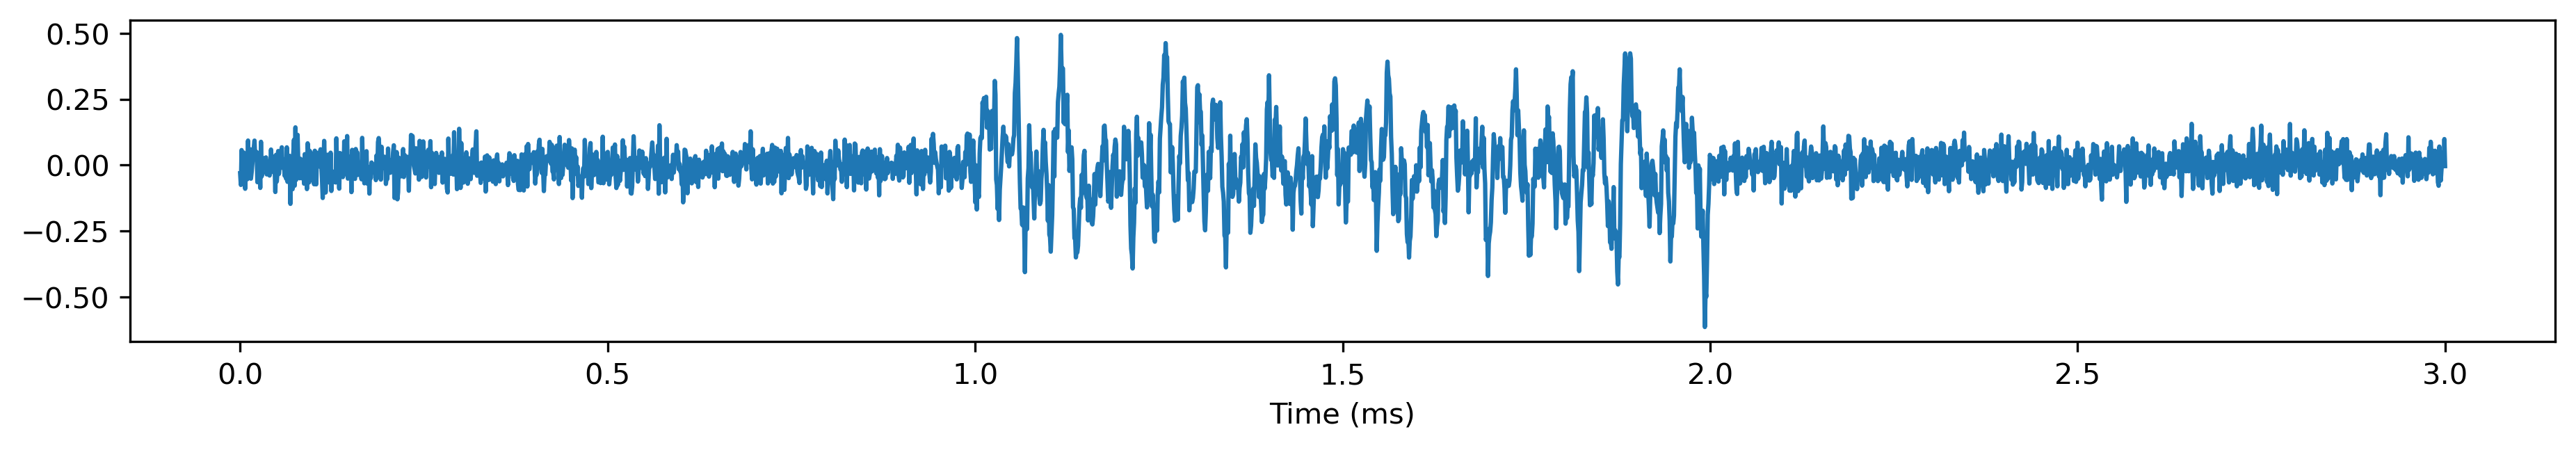

In [10]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(burst_signal)/fs, len(burst_signal)), burst_signal)

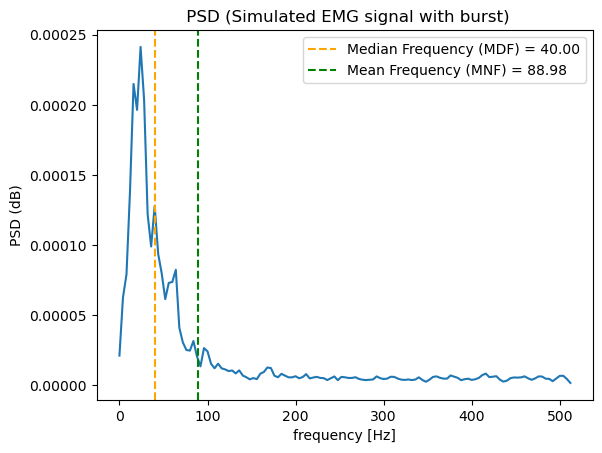

In [11]:
psd_welch, f_welch, MNF = superlet.compute_psd_welch(burst_signal, fs, plot=True, muscle='Simulated EMG signal with burst')
MNF_1 = [MNF]

In [12]:
MNF_1

[88.98464242893525]

### Definición del vector de frecuencia

In [13]:
freqs = np.linspace(20,500,int(fs/2)) # Número de puntos del vector frecuencia
freq_min = freqs[0]  # Minimum freq
freq_max = freqs[-1]  # Frecuencia máxima
num_freqs = len(freqs)  # Resolución del rango de frecuencias

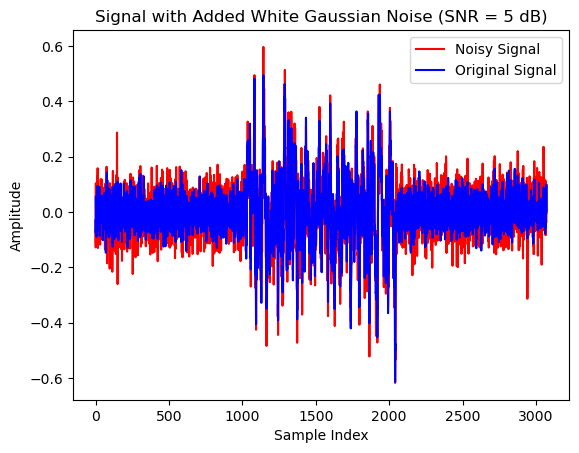

In [14]:
SNR = 5
# if 'SNR' not in globals():
#     SNR = "Inf"
signal_1 = superlet.add_noise(burst_signal, SNR, plot = True)

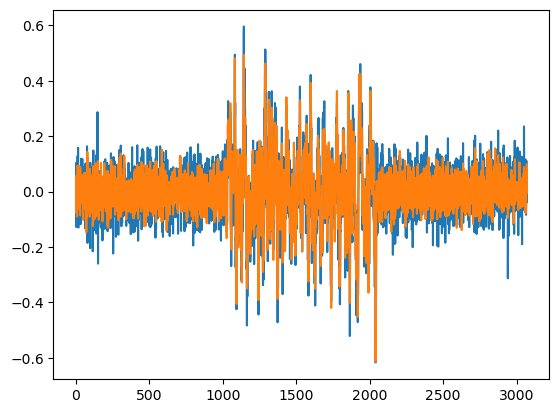

In [15]:
plt.figure()
plt.plot(signal_1)
plt.plot(burst_signal)

Reference mean frequency: [88.98464242893525] Hz


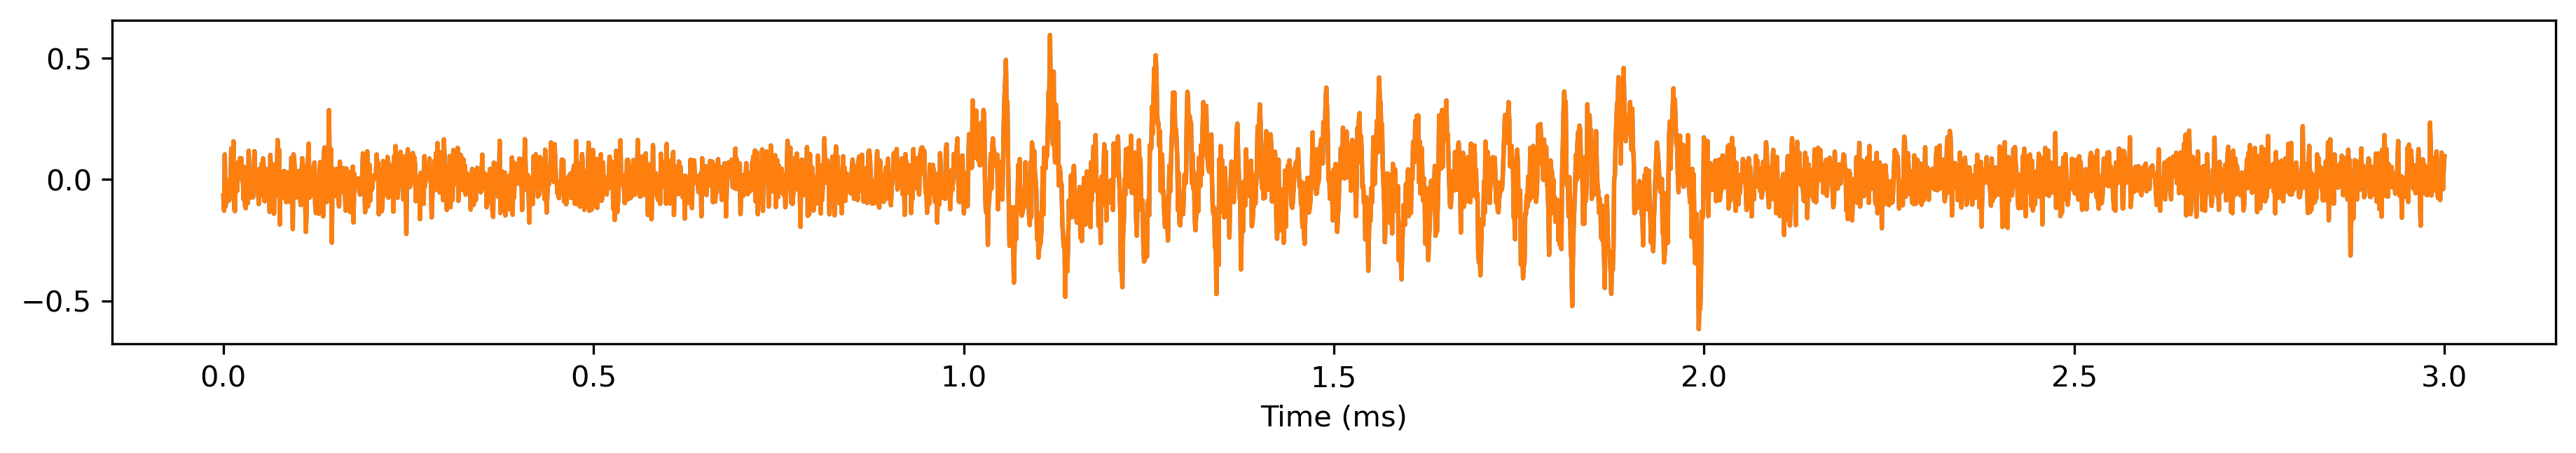

In [16]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(signal_1) / fs, len(signal_1)), signal_1)
print(f"Reference mean frequency: {MNF_1} Hz")
plt.plot(t, signal_1)

# WAVELET PARAMETERS = 3, 16, 33, 55, 60 cycles

In [17]:
params_wavelet = [3, 16, 33, 55, 60]

In [18]:
plot_scalogram = False
plot_imnf = False
plot_means = False

Estimated mean frequency: 112.46434374670848 Hz
Estimated onset = 0.981764897427548 s, offset = 2.009443178117877 s
Estimated mean frequency: 109.9549890274906 Hz
Estimated onset = 0.9553891240638228 s, offset = 2.0514490394008464 s
Estimated mean frequency: 109.91234824466984 Hz
Estimated onset = 0.9290133507000977 s, offset = 2.065125366330186 s
Estimated mean frequency: 110.5403463991579 Hz
Estimated onset = 0.9045913383262781 s, offset = 2.072940410289808 s
Estimated mean frequency: 110.68717803110152 Hz
Estimated onset = 0.9016606968414197 s, offset = 2.0748941712797135 s


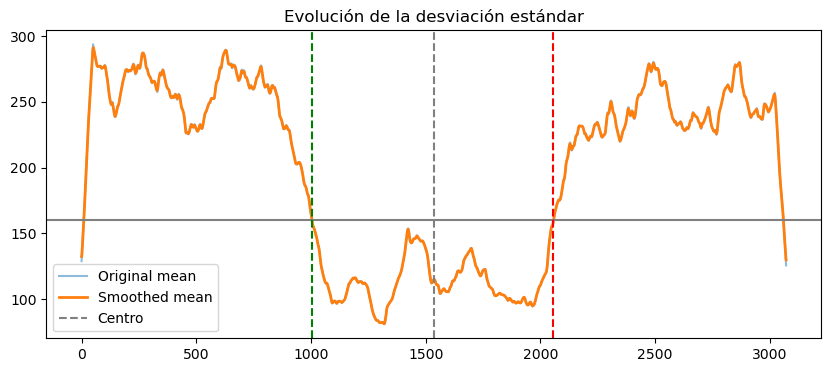

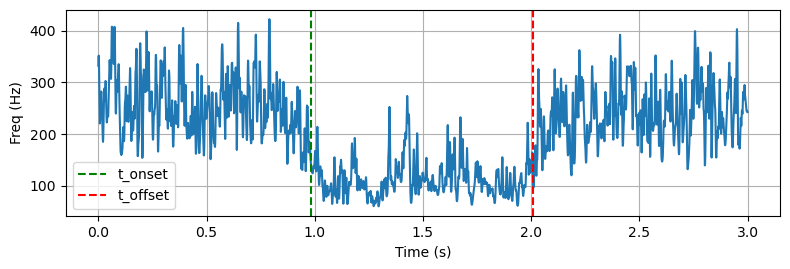

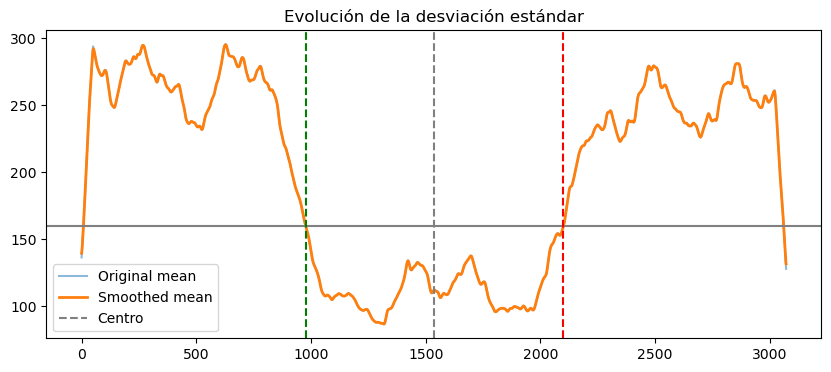

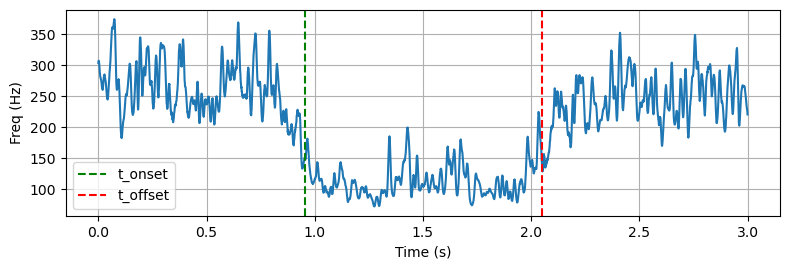

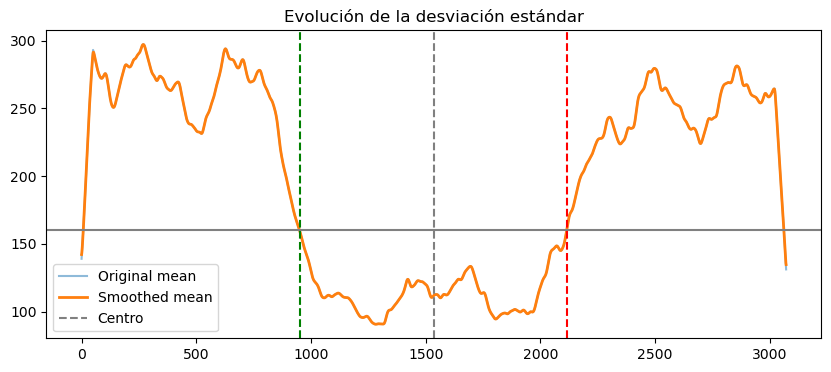

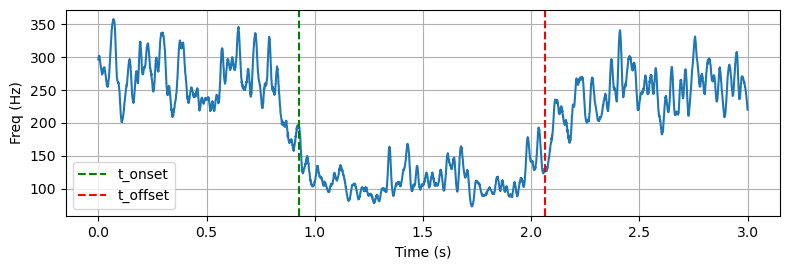

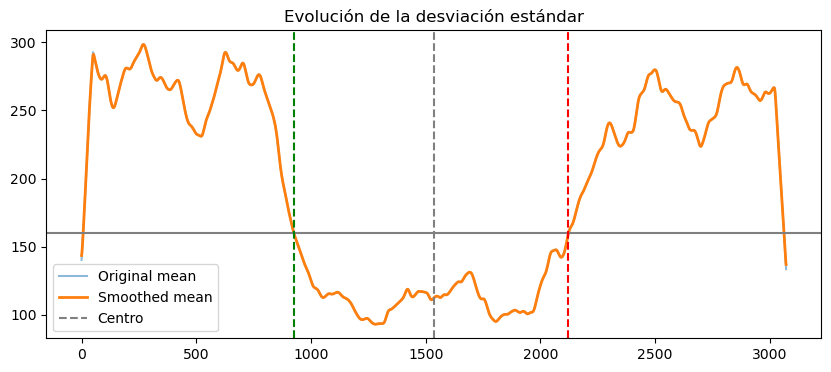

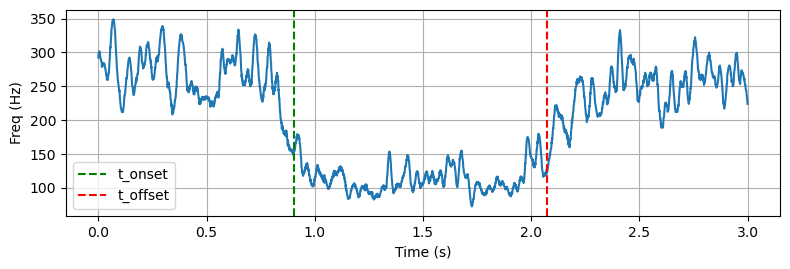

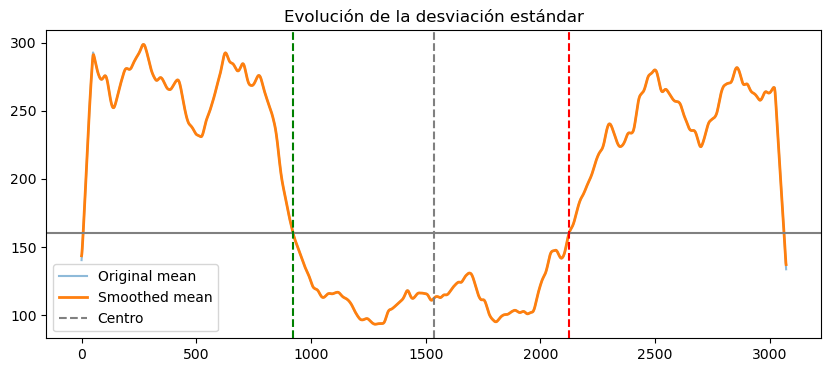

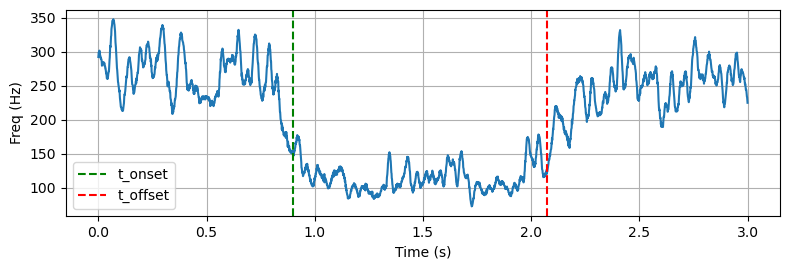

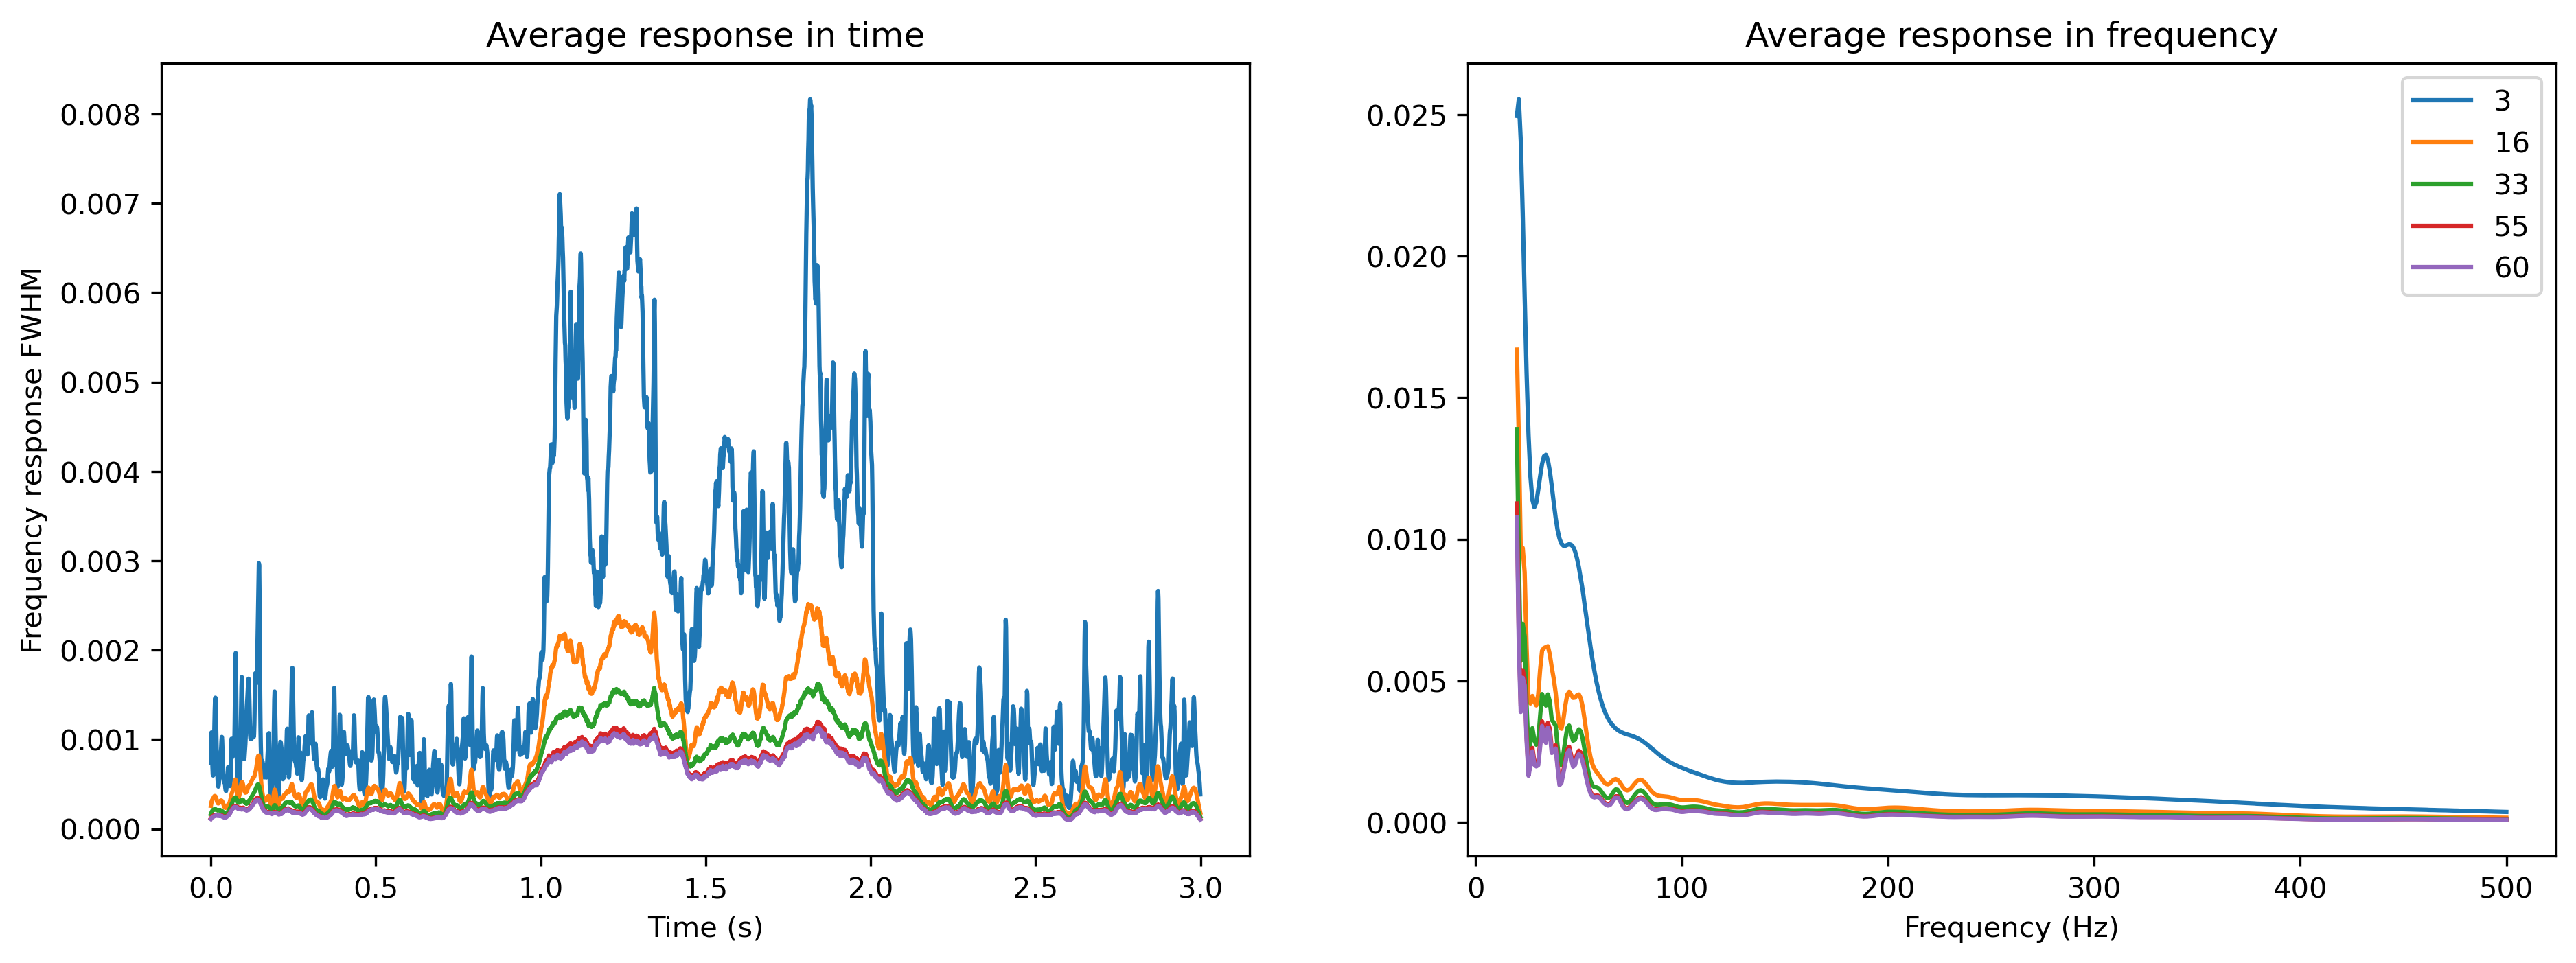

In [20]:
if plot_scalogram:
    fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(18,5), dpi=300)
if plot_imnf:
    fig_2, ax_2 = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_wavelet_f = []
std_wavelet_f = []

mae_wavelet_t = []
std_wavelet_t = []

total_time = []
total_freq = []

total_scalogram_wavelet = []
res_wavelet = []

for i, c in enumerate(params_wavelet):
    wavelet = f'cmor{c}-1.0'
    
    cwtmatr, f, physical_freqs = morlet.wavelet_transform_2(signal_1,wavelet,freqs,fs)
    cwtmatr = np.abs(cwtmatr[:,:])
    
    scalogram_2 = np.array(jnp.abs(cwtmatr)**2)
    
    if plot_scalogram:
        pcm = ax[i].pcolormesh(t,f, scalogram_2, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'c={c}')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()
        
    total_scalogram_wavelet.append(scalogram_2)
    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    
    # VALOR MEDIO EN UNA VENTANA DESLIZANTE
    window_size = 50
    sigma = 60
    # media_movil, slope_gradient, first_index, last_index = superlet.compute_smoothed_gradient(instant_freq, t, fs=fs, burst_start=burst_start, burst_duration=burst_duration, window_size=50, sigma=2)
    # 
    # first_index, last_index = superlet.find_low_oscillation_region(instant_freq, t, fs, burst_start, burst_duration, threshold=0.05, min_duration=burst_duration/2)
    
    first_index, last_index = superlet.find_plateau_region(instant_freq, burst_start, burst_duration, t, fs, std_threshold=160, smooth_sigma=2, validation_window=0.4)
    
    t_onset = t[first_index]
    t_offset = t[last_index]
       
    start_idx = np.searchsorted(t, burst_start)  # Encuentra el índice de inicio
    end_idx = np.searchsorted(t, burst_start + burst_duration)  # Encuentra el índice final
    
    instant_mean_freq_burst = instant_freq[start_idx:end_idx]
    
    if plot_imnf:
        ax_2[i].plot(t, instant_freq)

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(t[0], t[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].grid(True)

        ax_3.plot(t, instant_freq, label=f"Mean frequency (Cycles: {c})")
        plt.tight_layout()
        
        ax_3.set_xlabel("Time (s)")
        ax_3.set_ylabel("Frequency (Hz)")
        ax_3.legend()
        ax_3.grid(True)
        ax_3.set_title("Comparación de frecuencias medias instantáneas")
        
    #MAE in frequency
    print(f'Estimated mean frequency: {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = superlet.calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_wavelet_f.append(mae_f)
    std_wavelet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    mae_t, std_t = superlet.calculate_mae((t_onset,t_offset), (real_t_onset,real_t_offset))
    mae_wavelet_t.append(mae_t)
    std_wavelet_t.append(std_t)
    
    # Visualization
    plt.figure(figsize=(8, 5))

    plt.subplot(2, 1, 1)
    plt.plot(t, instant_freq)
    # plt.plot(t, media_movil)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()

    # plt.subplot(2, 1, 2)
    # # plt.plot(t, slope_gradient)
    # plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    # plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Freq (Hz)')
    # plt.legend()
    # plt.grid()

    plt.tight_layout()
    
    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)
    
res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, total_time, total_freq, params_wavelet)
    
    

In [21]:
mae_wavelet_f

[29.255273444764377,
 22.956145989715175,
 22.005725023567244,
 22.18015200611043,
 22.264674891697695]

In [22]:
mae_wavelet_t

[0.02767828069032896,
 0.09605991533702363,
 0.13611201563008812,
 0.16834907196352977,
 0.17323347443829384]

## PARÁMETROS SUPERLET: base_cycle, min_order, max_order = [3, 5, 1, 1, 1, 1], [1, 1, 5, 10, 20, 30], [30, 30, 40, 100, 100, 200]

In [23]:
params_superlet = [[1, 1, 3, 5, 5], [3, 5, 1, 1, 1], [30, 40, 30, 40, 50]]

Estimated mean frequency: 159.62895709304306 Hz
Estimated onset = 0.9856724194073592 s, offset = 1.9928362097036796 s
Estimated mean frequency: 161.18773468496403 Hz
Estimated onset = 0.9925105828720286 s, offset = 1.9938130901986324 s
Estimated mean frequency: 131.8181479000765 Hz
Estimated onset = 0.9690654509931619 s, offset = 2.0348420709866493 s
Estimated mean frequency: 121.67359828655842 Hz
Estimated onset = 0.9426896776294367 s, offset = 2.0602409638554215 s
Estimated mean frequency: 115.28831725941973 Hz
Estimated onset = 0.9309671116900032 s, offset = 2.068056007815044 s


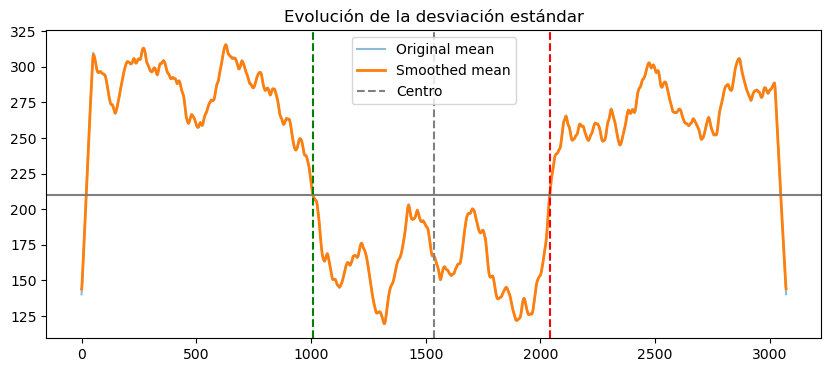

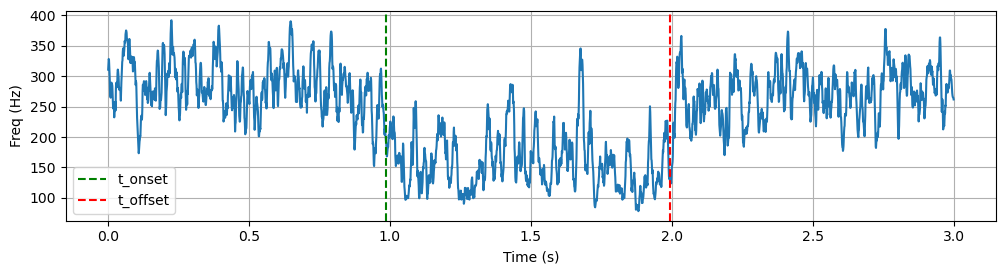

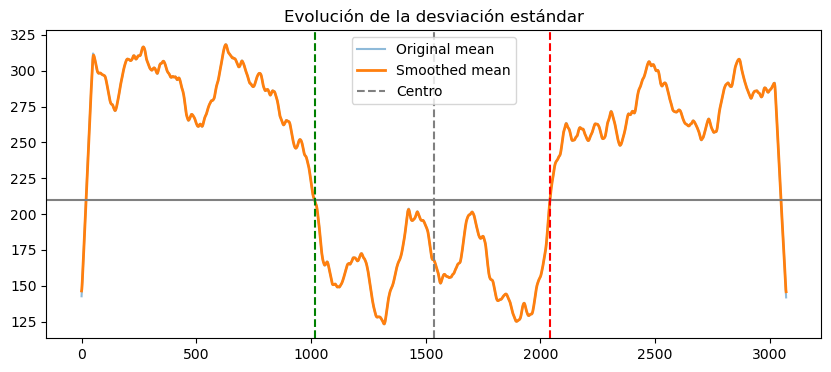

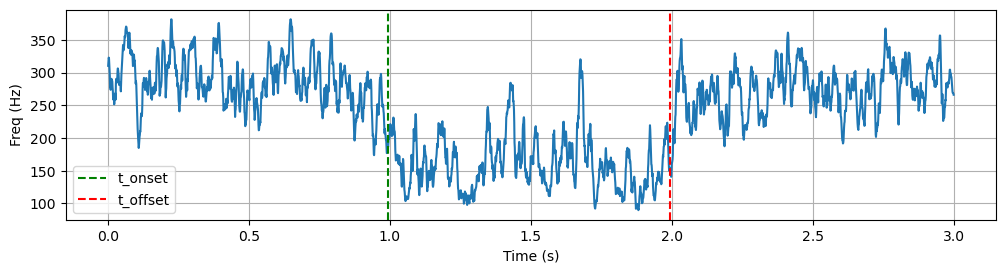

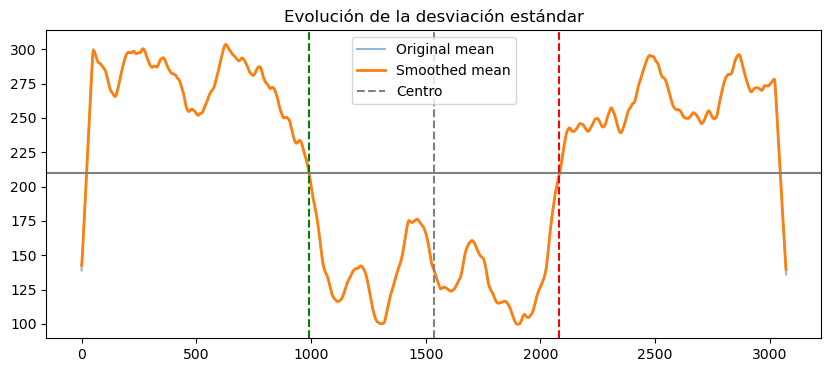

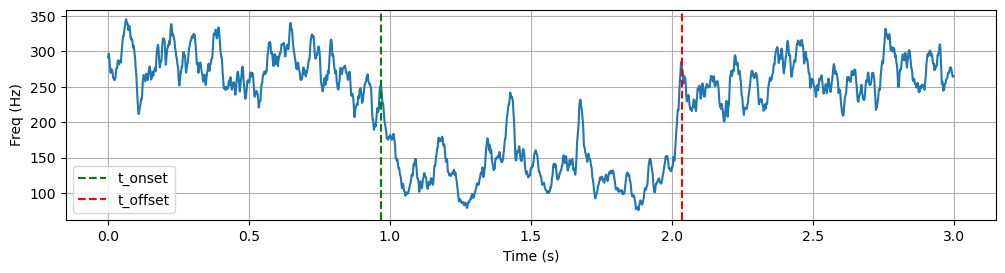

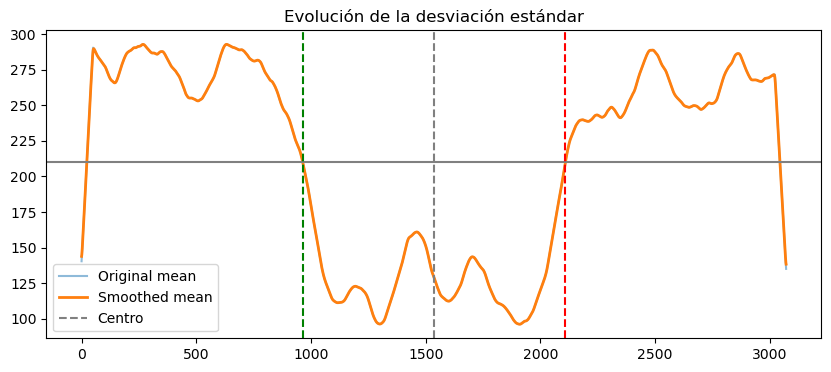

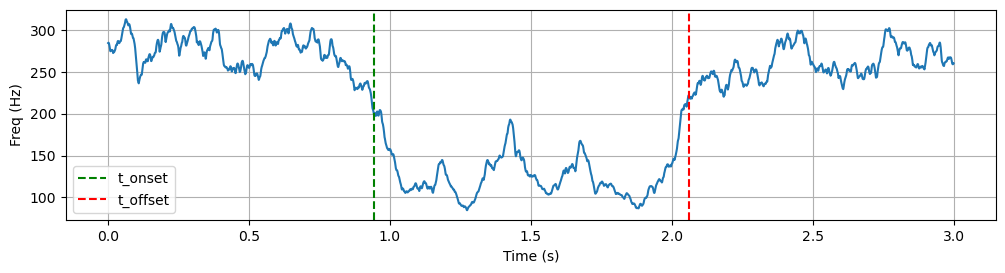

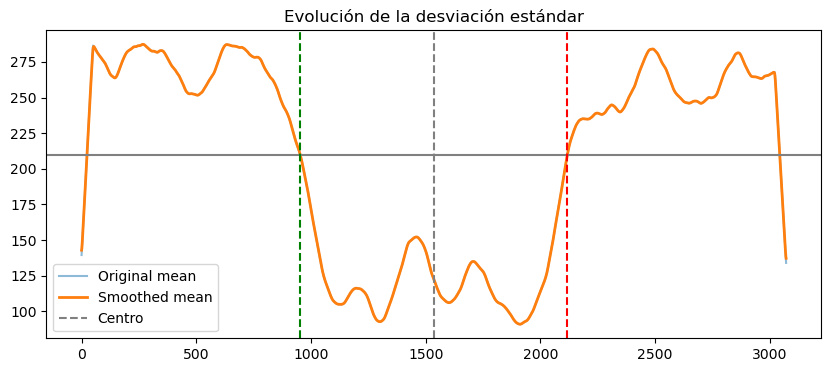

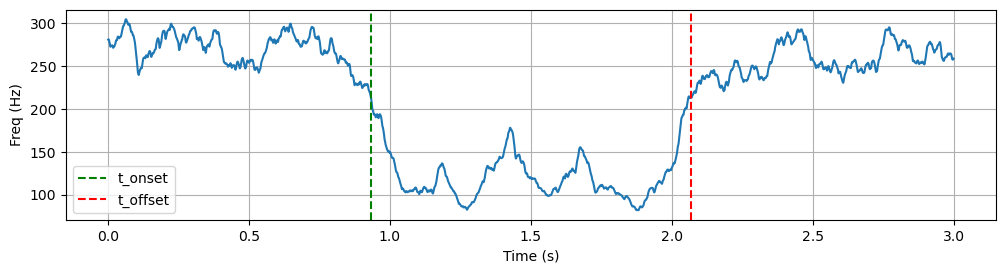

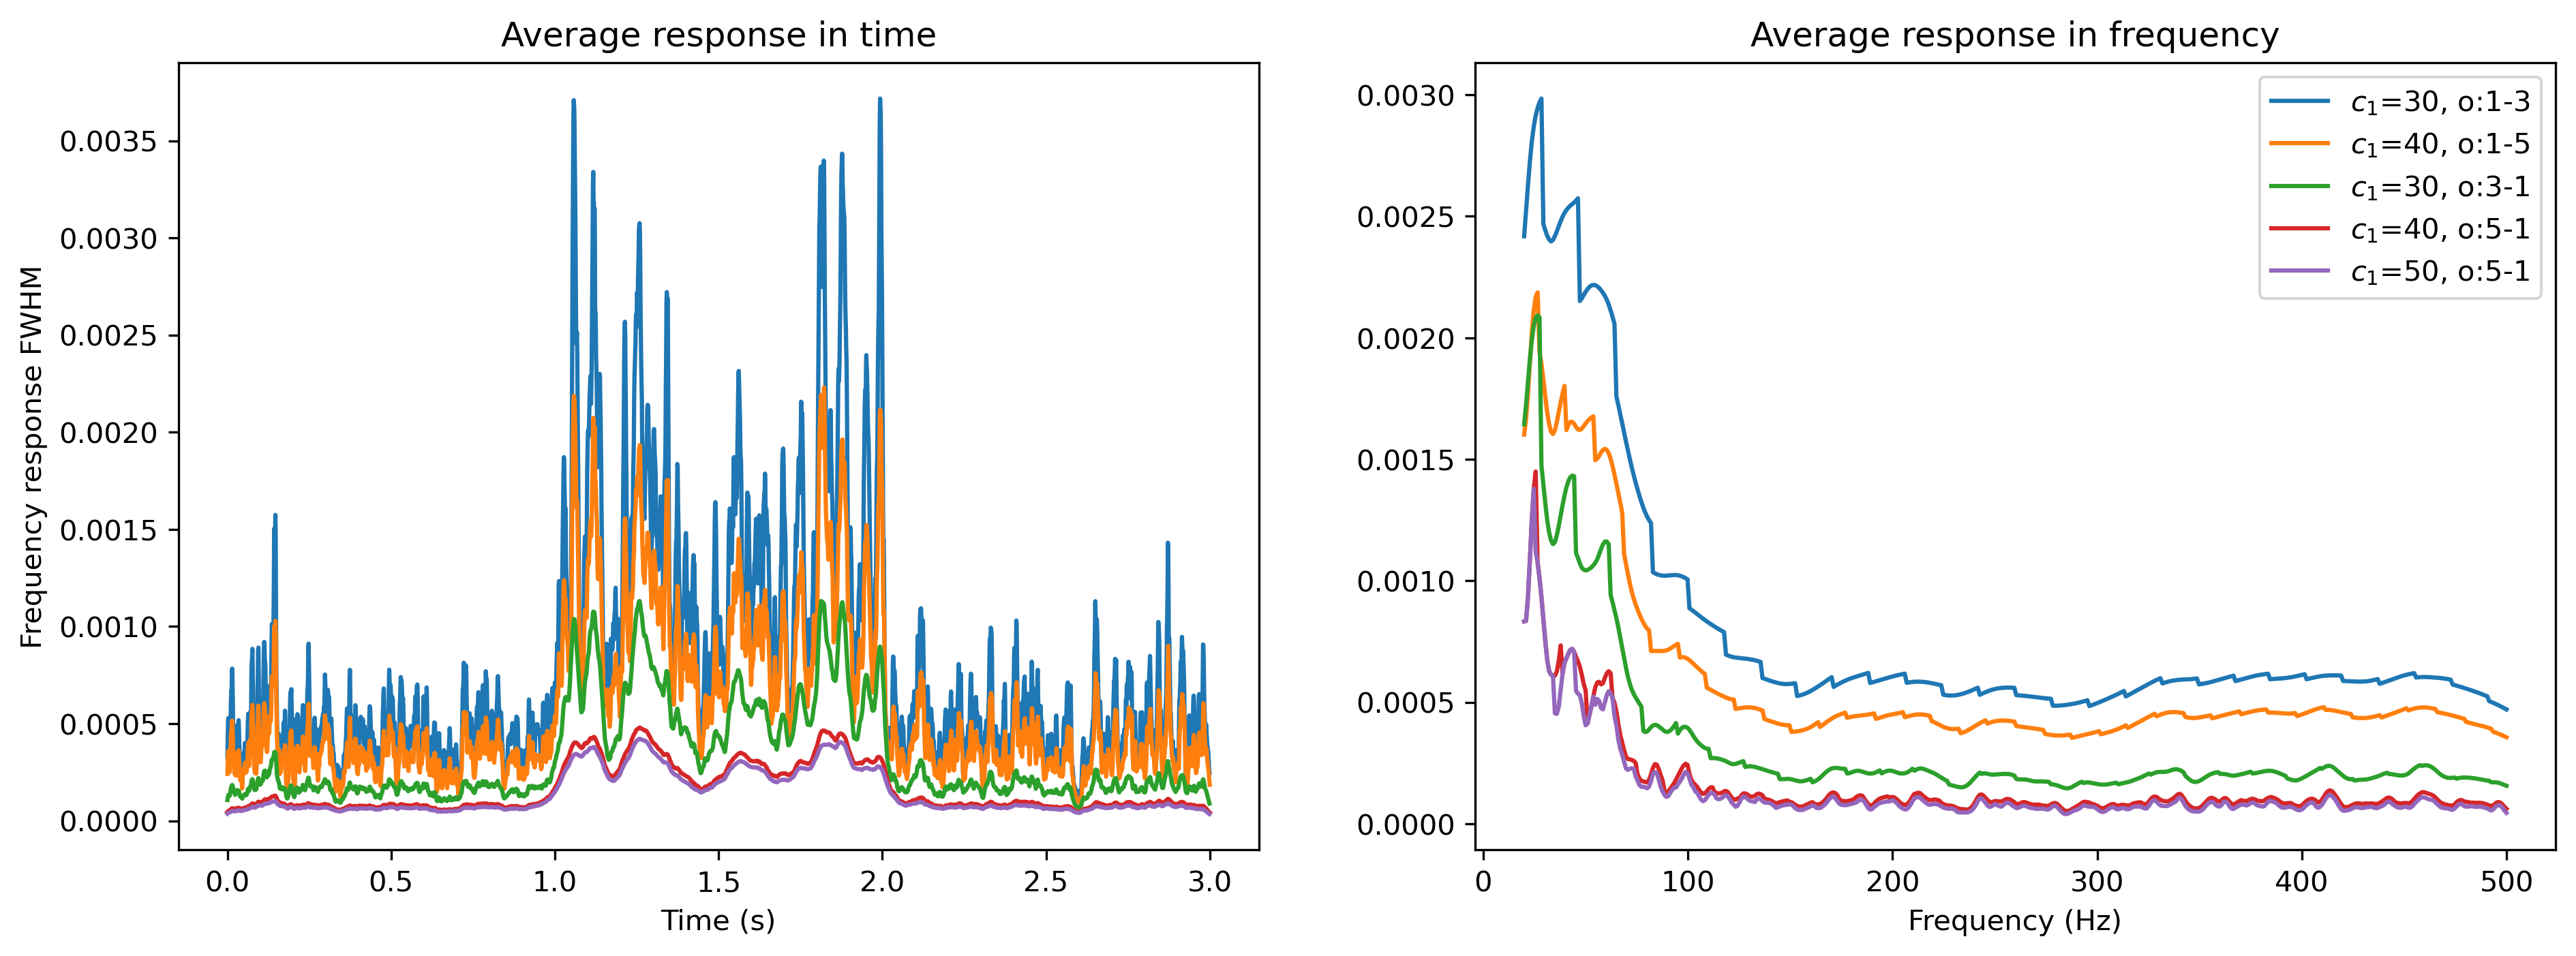

In [24]:
importlib.reload(superlet)

if plot_scalogram:
    fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(18,5), dpi=300)
if plot_imnf:
    fig_2, ax_2 = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_superlet_f = []
std_superlet_f = []

mae_superlet_t = []
std_superlet_t = []

total_time = []
total_freq = []

total_scalogram_superlet = []

for (i, (base_cycle, min_order, max_order)) in enumerate(zip(*params_superlet)):

    wv, scalogram = superlet.adaptive_superlet_transform(signal_1, freqs, sampling_freq=fs,
                                                         base_cycle=base_cycle, min_order=min_order,
                                                         max_order=max_order, mode="mul")
    
    if plot_scalogram:
        im = ax[i].imshow(jnp.abs(scalogram) ** 2, aspect='auto', cmap="jet", interpolation="none", origin="lower",extent=[0, len(signal_1) / fs, freqs[0], freqs[-1]])
        ax[i].set_title(f"$c_1$: {base_cycle}, o: {min_order}-{max_order}")
        ax[i].set_xlabel("Time (s)")
        ax[i].set_ylabel("Frequency (Hz)")

        cbar = fig.colorbar(im, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power [a.u]', rotation=0, labelpad=15)  # Etiqueta de la colorbar
        plt.tight_layout()

    scalogram_2 = np.abs(scalogram) ** 2

    total_scalogram_superlet.append(scalogram_2)
    
    instant_freq = np.sum(scalogram_2 * freqs[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    if plot_means:
        plt.figure()
        plt.plot(instant_freq)
        plt.title('Frecuencia instantánea')
        
    first_index, last_index = superlet.find_plateau_region(instant_freq, burst_start, burst_duration, t, fs, std_threshold=210, smooth_sigma=2, validation_window=0.4)
    
    t_onset = t[first_index]
    t_offset = t[last_index]
    
    instant_mean_freq_burst = instant_freq[start_idx:end_idx]
    
    if plot_imnf:
        ax_2[i].plot(t, instant_freq)

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(t[0], t[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].grid(True)

        ax_3.plot(t, instant_freq, label=f"Mean frequency (Cycles: {c})")
        plt.tight_layout()
        
        ax_3.set_xlabel("Time (s)")
        ax_3.set_ylabel("Frequency (Hz)")
        ax_3.legend()
        ax_3.grid(True)
        ax_3.set_title("Comparación de frecuencias medias instantáneas")
        
        #MAE in frequency
    print(f'Estimated mean frequency: {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = superlet.calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_superlet_f.append(mae_f)
    std_superlet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    # estimates_combined = t_offset - t_onset
    # print(f'Estimated difference: {estimates_combined} s')
    # true_values_combined = t_offset_1 - t_onset_1
    # print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = superlet.calculate_mae((t_onset,t_offset), (real_t_onset,real_t_offset))
    mae_superlet_t.append(mae_t)
    std_superlet_t.append(std_t)
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t, instant_freq)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()
    
    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)

    total_time.append(t)
    total_freq.append(freqs)

res_superlet = superlet.compute_avg_response_resolution(total_scalogram_superlet, total_time, total_freq, [f'$c_1$={c3}, o:{c1}-{c2}' for c1, c2, c3 in zip(*params_superlet)])

In [25]:
mae_superlet_f

[70.78788775963721,
 72.20309225602878,
 43.41650849089536,
 32.78576094018622,
 26.90087630476983]

In [26]:
mae_superlet_t

[0.021491370888961248,
 0.013676326929338956,
 0.06577661999348738,
 0.11755128622598487,
 0.13708889612504083]

## STFT PARAMETERS (window = duration/cycles) = 38, 200, 413, 550, 600, 824 ms

In [27]:
offset_burst = 0
offset = 0

Estimated mean frequency: np.mean(instant_mean_freq_burst) Hz
Estimated onset = 0.9807880169325952 s, offset = 1.986974926733963 s
Estimated mean frequency: np.mean(instant_mean_freq_burst) Hz
Estimated onset = 0.9651579290133507 s, offset = 2.036795831976555 s
Estimated mean frequency: np.mean(instant_mean_freq_burst) Hz
Estimated onset = 0.9397590361445783 s, offset = 2.068056007815044 s
Estimated mean frequency: np.mean(instant_mean_freq_burst) Hz
Estimated onset = 0.9241289482253338 s, offset = 2.0885704982090525 s
Estimated mean frequency: np.mean(instant_mean_freq_burst) Hz
Estimated onset = 0.9192445457505699 s, offset = 2.0963855421686746 s


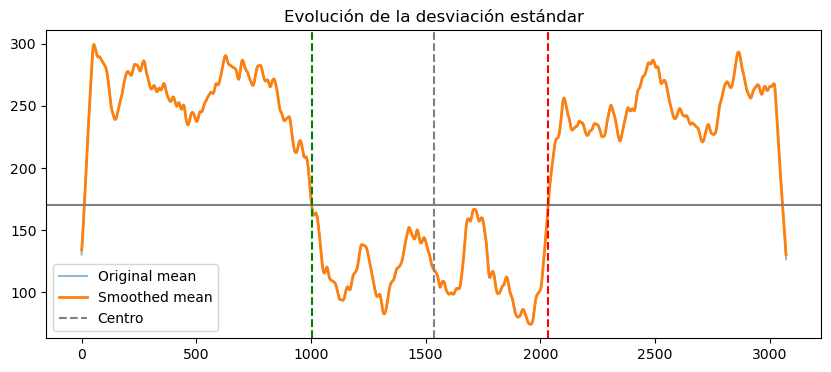

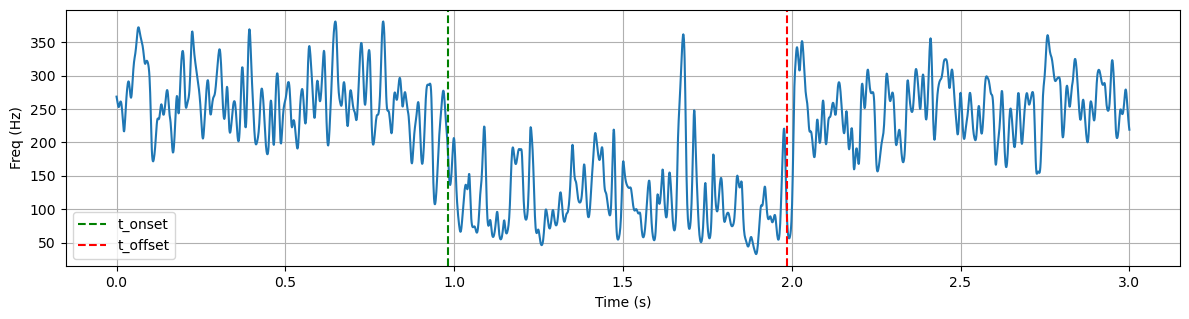

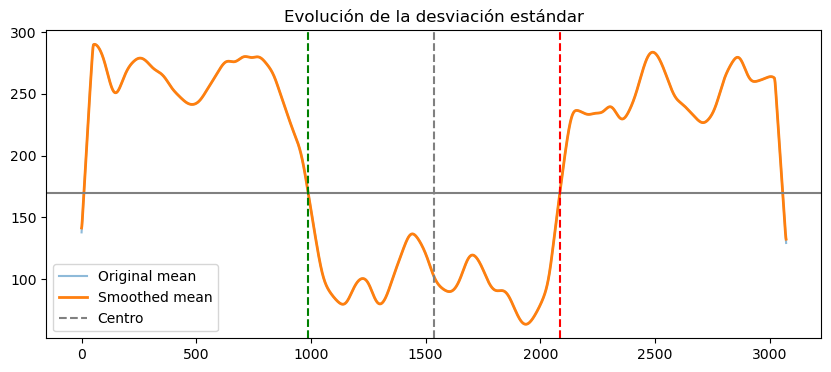

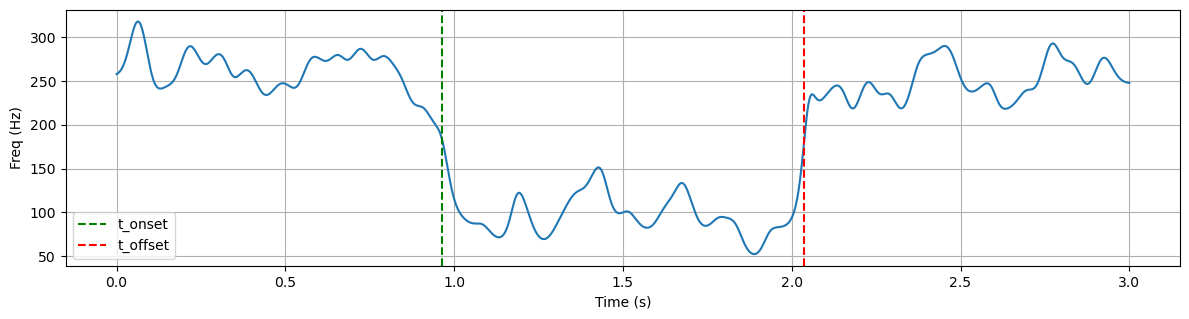

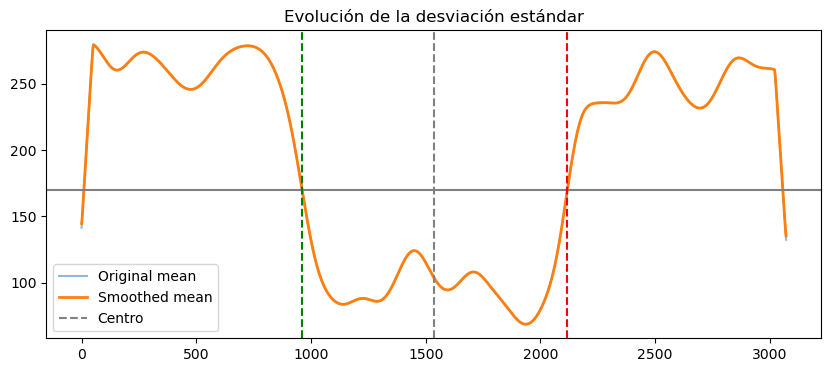

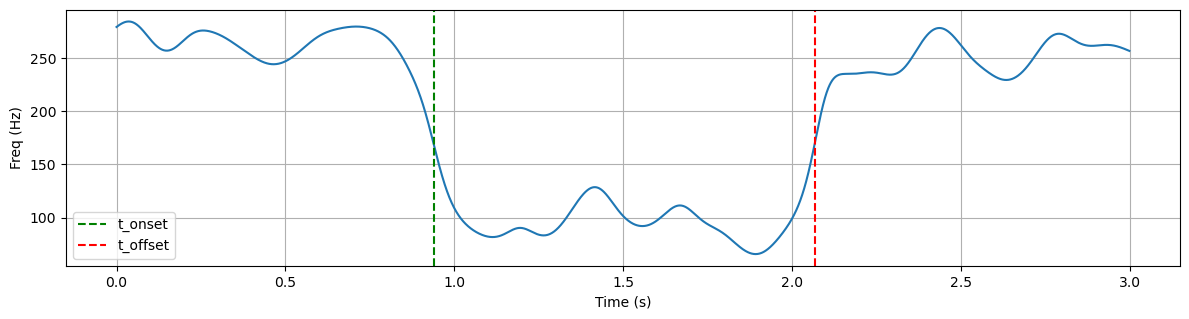

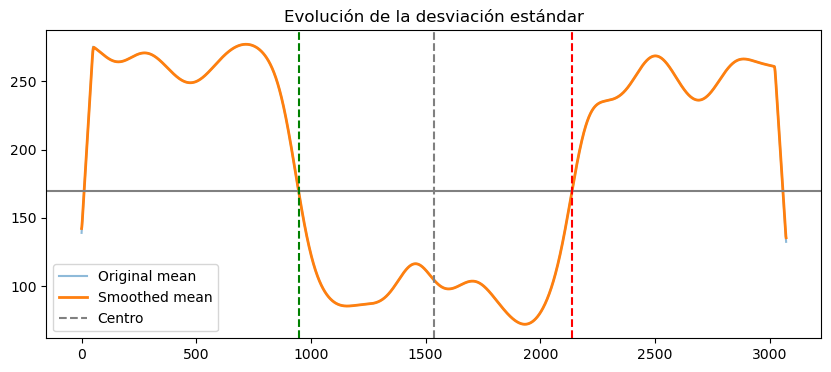

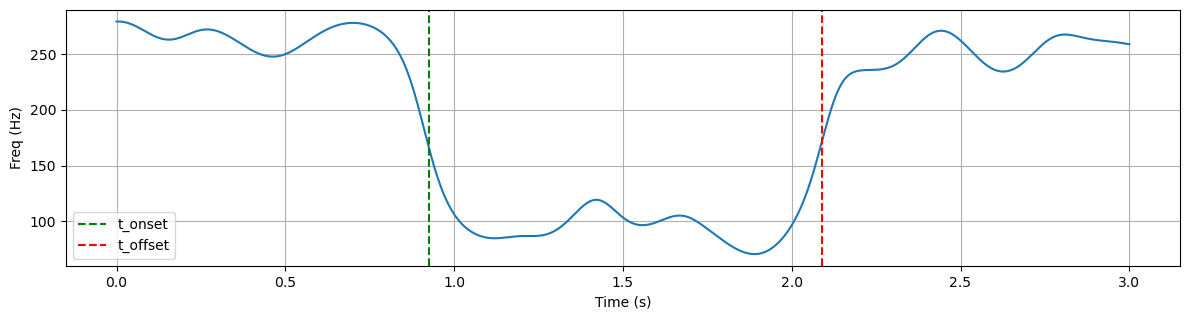

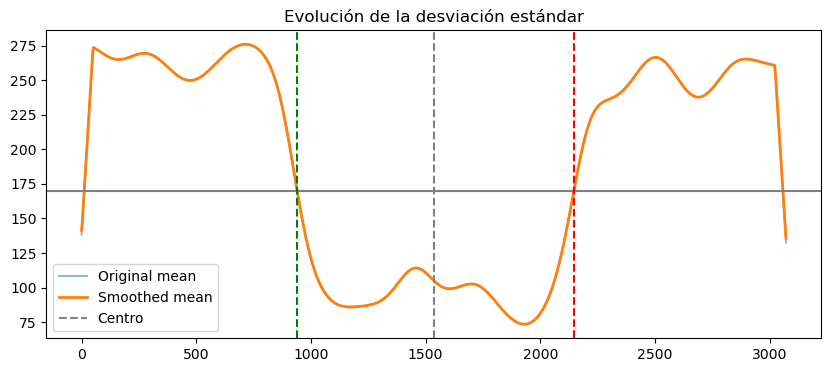

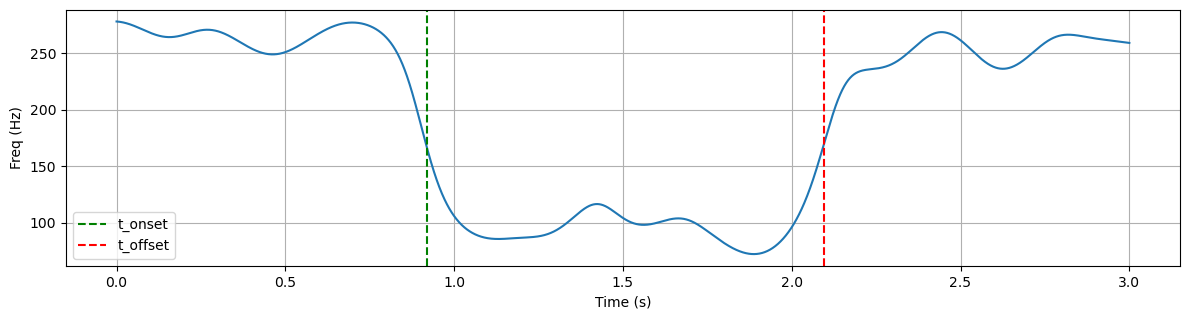

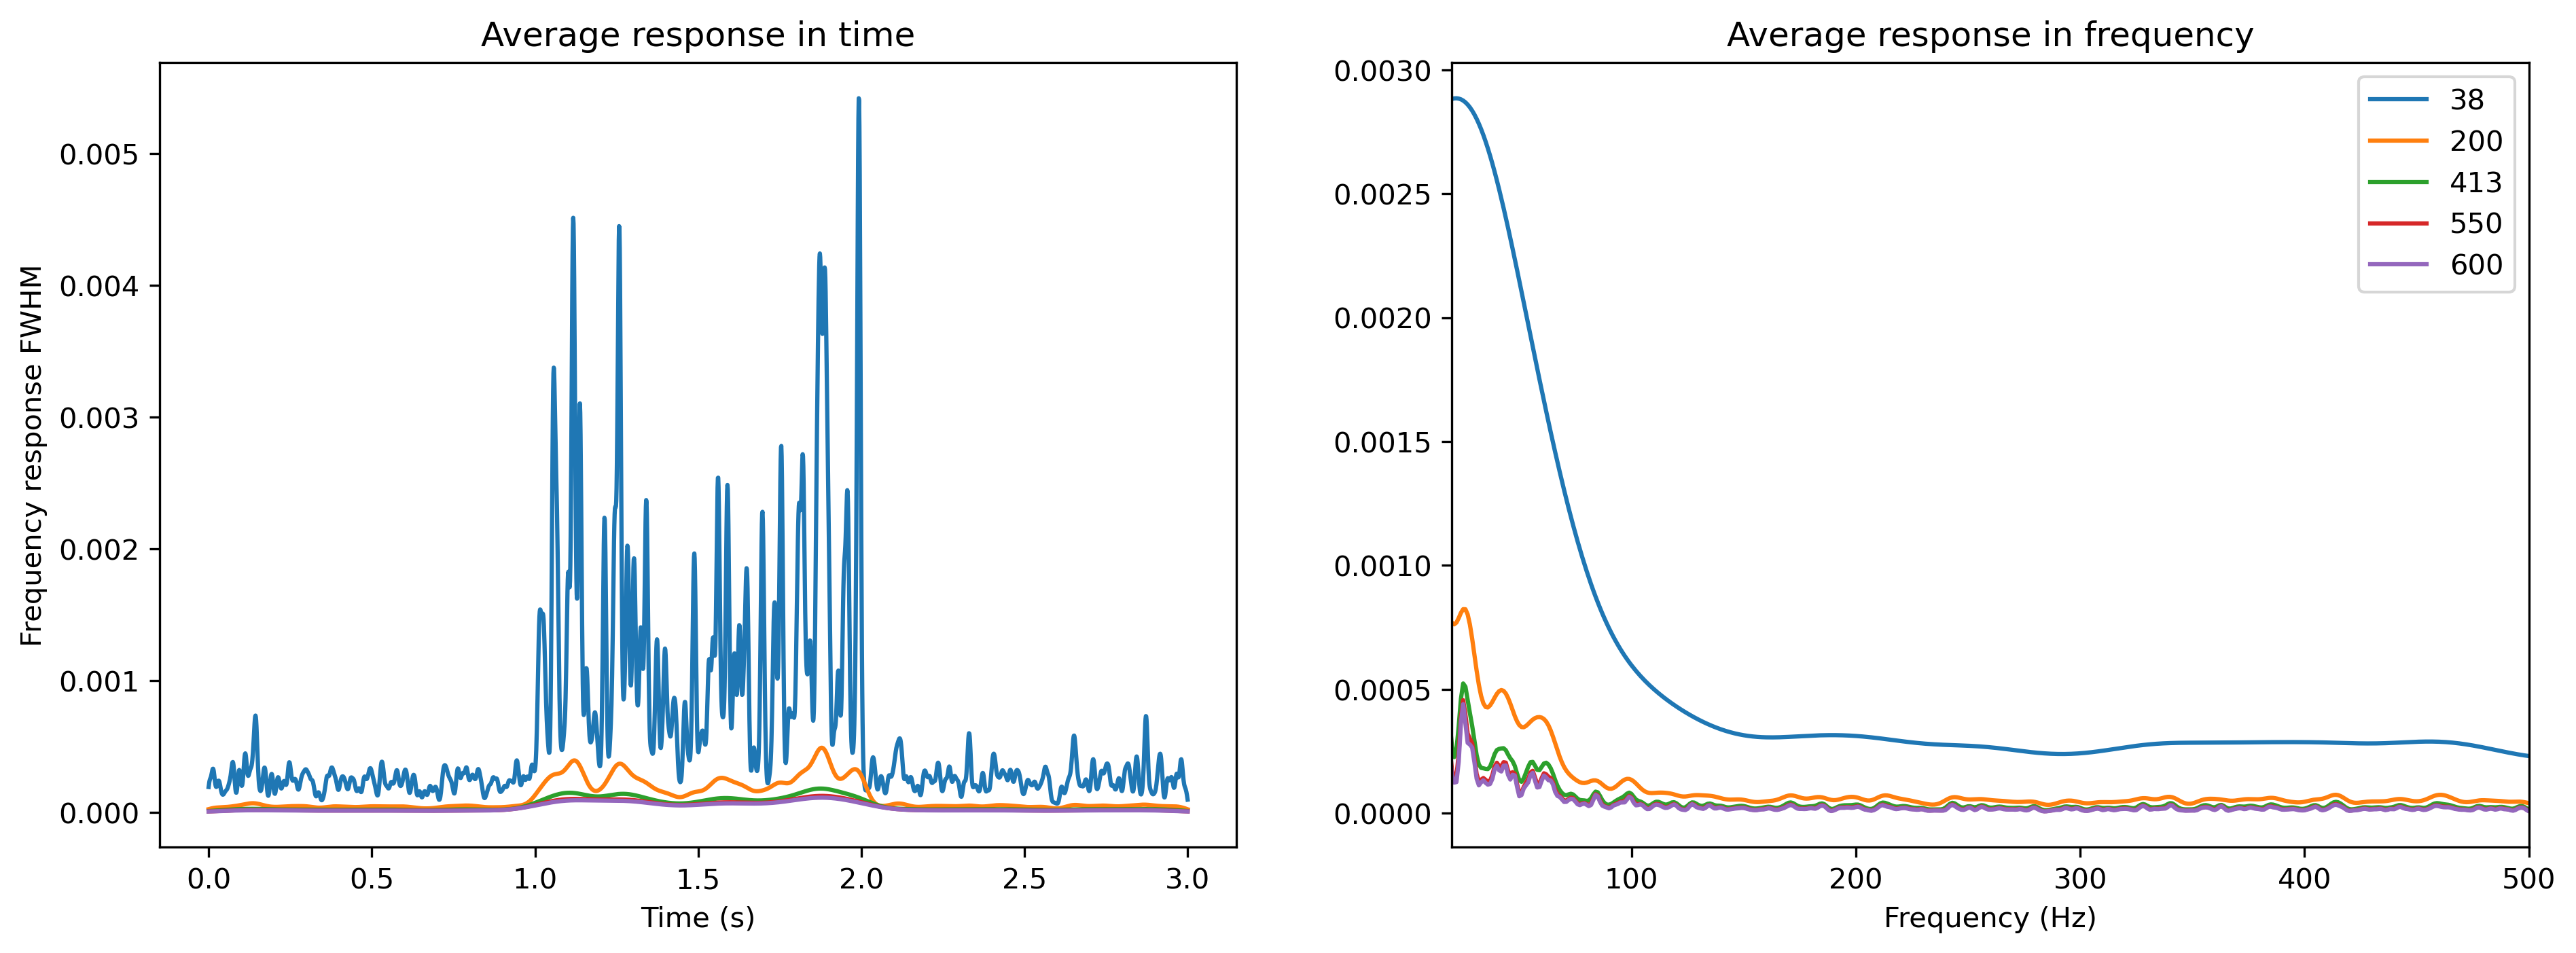

In [28]:
from scipy.signal import stft
from scipy.signal import windows

windows_ms = [38, 200, 413, 550, 600]

if plot_scalogram:
    fig, ax = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)

if plot_imnf:
    fig_2, ax_2 = plt.subplots(ncols=len(windows_ms), figsize=(15, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_stft_f = []
std_stft_f = []

mae_stft_t = []
std_stft_t = []

total_time = []
total_freq = []

res_stft = []
total_scalogram_stft = []

for i, w in enumerate(windows_ms):
    # Calcular la ventana Blackman
    window = windows.blackman(w)
    
    # Hacer que la f de la stft tenga el mismo tamaño que las demás
    nfft = 2 * (len(freqs))

    f, t_stft, Zxx = stft(signal_1, fs=fs, window='blackman', nperseg=w, noverlap=w-1, nfft=nfft, detrend=False, return_onesided=True, boundary='zeros', padded=True, axis=-1, scaling='spectrum')

    # Calcular la representación de potencia (magnitud al cuadrado)
    Zxx_power = np.abs(Zxx) ** 2
    
    if plot_scalogram:
        pcm = ax[i].pcolormesh(t_stft, f, Zxx_power, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'W={w * 1000 // fs} ms')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        #fig.colorbar(pcm, ax=ax[i], label='Potencia')
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()
    
    scalogram_2 = Zxx_power
    
    #if np.any(np.isnan(jnp.abs(Zxx)**2)) or np.any(np.isinf(jnp.abs(Zxx)**2)):
    #scalogram_2 = jnp.nan_to_num(jnp.abs(Zxx)**2, nan=0.0, posinf=0.0, neginf=0.0)
    
    total_scalogram_stft.append(scalogram_2)
    
    # Para evitar la división por cero
    denominador = np.sum(scalogram_2, axis=0)
    # denominador = np.where(denominador == 0, 1e-10, denominador)
    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / denominador
    
    first_index, last_index = superlet.find_plateau_region(instant_freq, burst_start, burst_duration, t, fs, std_threshold=170, smooth_sigma=2, validation_window=0.4)
    
    t_onset = t[first_index]
    t_offset = t[last_index]

    instant_mean_freq_burst = instant_freq[start_idx:end_idx]

    if plot_imnf:
        ax_2[i].plot(t, instant_freq)

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(t[0], t[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].grid(True)

        ax_3.plot(t, instant_freq, label=f"Mean frequency (Cycles: {c})")
        plt.tight_layout()
        
        ax_3.set_xlabel("Time (s)")
        ax_3.set_ylabel("Frequency (Hz)")
        ax_3.legend()
        ax_3.grid(True)
        ax_3.set_title("Comparación de frecuencias medias instantáneas")

    #MAE in frequency
    print(f'Estimated mean frequency: np.mean(instant_mean_freq_burst) Hz')
    mae_f, std_f = superlet.calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_stft_f.append(mae_f)
    std_stft_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    # estimates_combined = t_offset - t_onset
    # print(f'Estimated difference: {estimates_combined} s')
    # true_values_combined = t_offset_1 - t_onset_1
    # print(f'Real difference: {true_values_combined} s')

    mae_t, std_t = superlet.calculate_mae((t_onset,t_offset), (real_t_onset,real_t_offset))
    mae_stft_t.append(mae_t)
    std_stft_t.append(std_t)
    
    # Visualization
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(t_stft, instant_freq)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    
    total_time.append(np.linspace(t_stft[0], t_stft[-1], scalogram_2.shape[1]))
    total_freq.append(np.linspace(f[0], f[-1], scalogram_2.shape[0]))

res_stft = superlet.compute_avg_response_resolution(total_scalogram_stft, total_time, total_freq, windows_ms, stft=[freqs[0],freqs[-1]])

In [29]:
mae_stft_f

[40.682038410058794,
 16.948803088974717,
 12.167009461167442,
 10.595812854850774,
 10.118190228038687]

In [30]:
mae_stft_t

[0.03223705633344187,
 0.07163790296320416,
 0.12829697167046572,
 0.16444154998371874,
 0.17714099641810466]

# Plot comparison of the same SNR

## MAE IN FREQUENCY

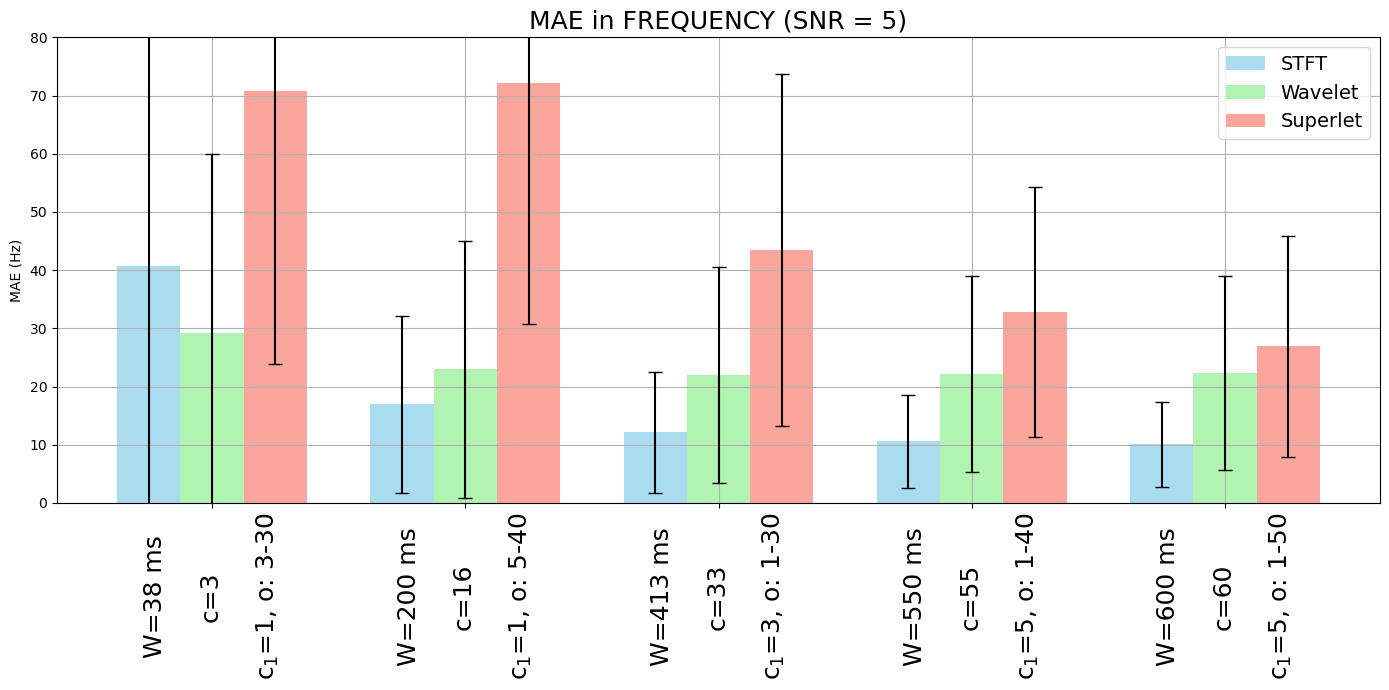

In [31]:
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet_f)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft_f, width=bar_width, yerr=std_stft_f, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet_f, width=bar_width, yerr=std_wavelet_f, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet_f, width=bar_width, yerr=std_superlet_f, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 81, 10))

plt.ylabel('MAE (Hz)')
plt.title('MAE in FREQUENCY (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,80)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# MAE IN TIME

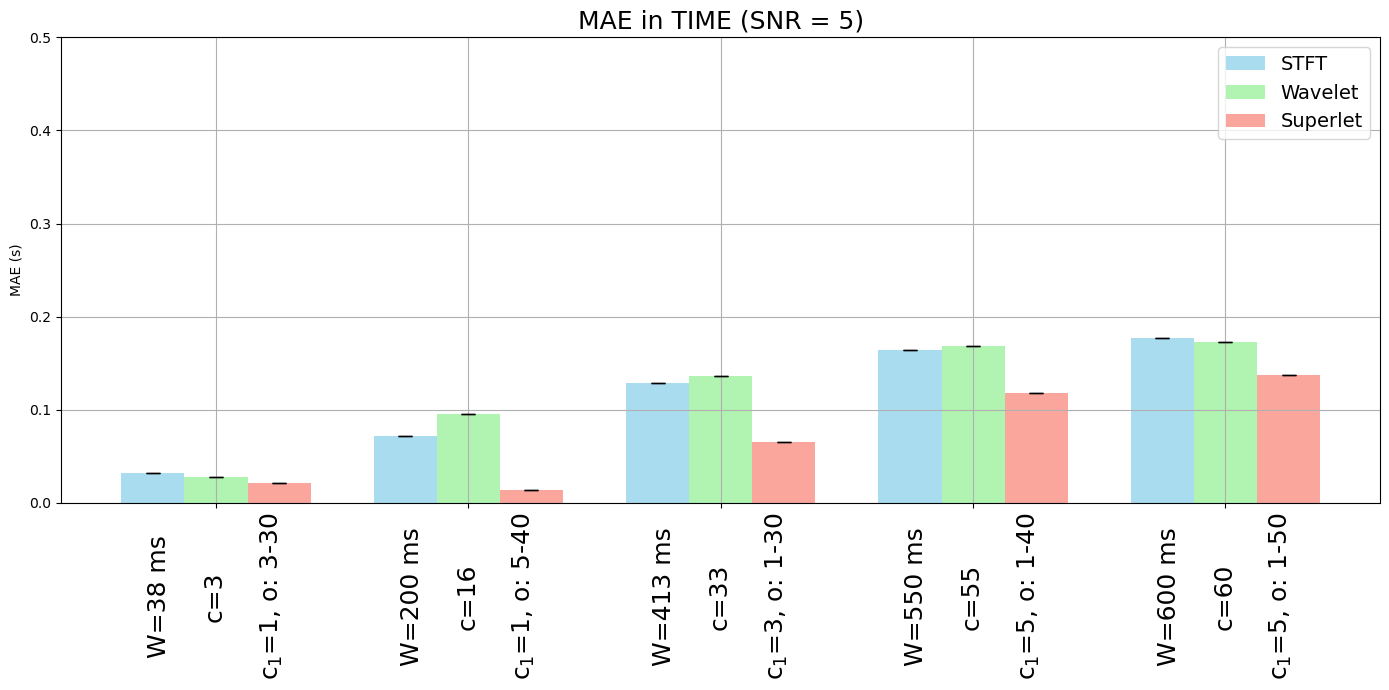

In [33]:
params_stft = windows_ms

# Número de condiciones
num_conditions = len(mae_wavelet_t)
x = np.arange(num_conditions)  # Posiciones para cada grupo de barras
bar_width = 0.25  # Ancho de las barras

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))

# Graficar cada técnica con sus valores y barras de error
plt.bar(x - bar_width, mae_stft_t, width=bar_width, yerr=std_stft_t, capsize=5, label='STFT', color='skyblue', alpha=0.7)
plt.bar(x, mae_wavelet_t, width=bar_width, yerr=std_wavelet_t, capsize=5, label='Wavelet', color='lightgreen', alpha=0.7)
plt.bar(x + bar_width, mae_superlet_t, width=bar_width, yerr=std_superlet_t, capsize=5, label='Superlet', color='salmon', alpha=0.7)

# Configuración de etiquetas en el eje x con los parámetros específicos
labels = [
    f"W={p_stft} ms\n\nc={p_w}\n\nc$_1$={p_s[0]}, o: {p_s[1]}-{p_s[2]}"
    for p_w, p_s, p_stft in zip(params_wavelet, zip(*params_superlet), params_stft)
]

plt.xticks(x, labels, rotation=90, ha='center', fontsize=18)
#plt.xlabel('Condiciones y Parámetros')
plt.yticks(np.arange(0, 0.6, 0.1))

plt.ylabel('MAE (s)')
plt.title('MAE in TIME (SNR = ' + str(SNR) +')', fontsize=18)
plt.ylim(0,0.5)
plt.legend(fontsize=14)
plt.grid(True)

# Ajustar el layout para mejorar visualización de etiquetas
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# WE REPEAT EVERYTHING WITH A DIFFERENT SNR

In [ ]:
noise = np.random.normal(0, 0.08, len(t))
baseline = noise.copy()
baseline[int(burst_start* fs):int(burst_start * fs + len(burst))] = burst

In [ ]:
fig, ax = plt.subplots(figsize=(15, 2), dpi=300)
ax.set_xlabel("Time (ms)")
ax.plot(jnp.linspace(0, len(baseline) / fs, len(baseline)), baseline)
print(f"Reference mean frequency: {MNF_1} Hz")

In [ ]:
SNR = 5
# if 'SNR' not in globals():
#     SNR = "Inf"
signal_noise_1 = superlet.add_noise(baseline, SNR, plot = True)

In [ ]:
plt.figure()
plt.plot(signal_noise)
plt.plot(signal_noise_1)
#plt.plot(baseline)

In [ ]:
signal = []
signal = signal_noise_1.copy()

# WAVELET PARAMETERS = 3, 16, 33, 55, 60 115 cycles

In [ ]:
plot_imnf = True

In [ ]:
# signal = []
# signal = signal_noise_1

In [ ]:
if plot_scalogram:
    fig, ax = plt.subplots(ncols=len(params_wavelet), figsize=(18,5), dpi=300)
if plot_imnf:
    fig_2, ax_2 = plt.subplots(ncols=len(params_wavelet), figsize=(18, 5), dpi=300)
    fig_3, ax_3 = plt.subplots(figsize=(10, 6))

mae_wavelet_f = []
std_wavelet_f = []

mae_wavelet_t = []
std_wavelet_t = []

total_time = []
total_freq = []

total_scalogram_wavelet = []
res_wavelet = []

for i, c in enumerate(params_wavelet):
    wavelet = f'cmor{c}-1.0'
    
    cwtmatr, f, physical_freqs = morlet.wavelet_transform_2(signal,wavelet,freqs,fs)
    cwtmatr = np.abs(cwtmatr[:,:])
    
    scalogram_2 = np.array(jnp.abs(cwtmatr)**2)
    
    if plot_scalogram:
        pcm = ax[i].pcolormesh(t,f, scalogram_2, shading='gouraud', cmap='jet')
        
        ax[i].set_title(f'c={c}')
        ax[i].set_ylabel('Frecuencia [Hz]')
        ax[i].set_xlabel('Tiempo [s]')
        
        cbar = fig.colorbar(pcm, ax=ax[i], orientation='horizontal')
        cbar.set_label('Power', rotation=0, labelpad=15)  # Etiqueta de la colorbar
    
        ax[i].set_ylim(freqs[0], freqs[-1])  # Ajustar el rango de frecuencias si es necesario
        plt.tight_layout()
        
    total_scalogram_wavelet.append(scalogram_2)
    instant_freq = np.sum(scalogram_2 * f[:, np.newaxis], axis=0) / np.sum(scalogram_2, axis=0)
    
    # VALOR MEDIO EN UNA VENTANA DESLIZANTE
    # Calcular la media móvil con convolución
    media_movil = np.convolve(instant_freq, window, mode='same')  
    media_movil = gaussian_filter1d(media_movil, sigma)
    slope_gradient = np.gradient(media_movil, t)
    
    if plot_means:
        plt.figure()
        plt.plot(media_movil, color = 'red')
        plt.title('Media de la señal')

        plt.figure()
        plt.plot(slope_gradient, color = 'green')
        plt.title('Gradiente de la media de la señal')
    
    first_index = np.argmin(slope_gradient[inicio:center]) + inicio
    last_index = np.argmax(slope_gradient[center:final]) + center
    
    t_onset = t[first_index]
    t_offset = t[last_index]
    
    instant_mean_freq_burst = instant_freq[start_idx:end_idx]
    
    if plot_imnf:
        ax_2[i].plot(t, instant_freq)

        ax_2[i].set_xlabel("Time (s)")
        ax_2[i].set_ylabel("Frequency (Hz)")
        #ax_2[i].set_xlim(t[0], t[-1])
        #plt.title("Medias de cada fila en función del tiempo")
        ax_2[i].grid(True)

        ax_3.plot(t, instant_freq, label=f"Mean frequency (Cycles: {c})")
        plt.tight_layout()
        
        ax_3.set_xlabel("Time (s)")
        ax_3.set_ylabel("Frequency (Hz)")
        ax_3.legend()
        ax_3.grid(True)
        ax_3.set_title("Comparación de frecuencias medias instantáneas")
        
    #MAE in frequency
    print(f'Estimated mean frequency: {np.mean(instant_mean_freq_burst)} Hz')
    mae_f, std_f = superlet.calculate_mae(instant_mean_freq_burst, MNF_1)
    mae_wavelet_f.append(mae_f)
    std_wavelet_f.append(std_f)
    
    #MAE in time
    print(f'Estimated onset = {t_onset} s, offset = {t_offset} s')
    mae_t, std_t = superlet.calculate_mae((t_onset,t_offset), (real_t_onset,real_t_offset))
    mae_wavelet_t.append(mae_t)
    std_wavelet_t.append(std_t)
    
    # Visualization
    plt.figure(figsize=(8, 5))

    plt.subplot(2, 1, 1)
    #plt.plot(t, instant_freq)
    plt.plot(t, media_movil)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(t, slope_gradient)
    plt.axvline(t_onset, color='green', linestyle='--', label='t_onset')
    plt.axvline(t_offset, color='red', linestyle='--', label='t_offset')
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    
    time = np.arange(scalogram_2.shape[1]) / fs

    total_time.append(time)
    total_freq.append(freqs)
    
res_wavelet = superlet.compute_avg_response_resolution(total_scalogram_wavelet, total_time, total_freq, params_wavelet)

In [ ]:
mae_wavelet_f

In [ ]:
mae_wavelet_t